In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
import rigidbody.kinematics as kine
import rigidbody.plotter as plotter
import rigidbody.ode_solver as ode

In [3]:
plotter.set_context("paper")

In [4]:
def kinematic_dynamic(x, nu):
    """
    Kinematic of a two-dimensional movement.
    The state x contains (x,y,phi).

    Parameters
    ----------
    t: float
    x: np.ndarray (3,)

    Returns
    -------
    dx_dt: np.ndarray (3,)
    """
    j_inv = kine.inverse_analytical_jacobian_2d(x[-1])
    return j_inv@nu

In [5]:
trajectory_init = np.array([0.,0.,0.])
N_t = 300
dt = 1e-2
t_span = np.arange(N_t)*dt
trajectory = np.zeros((t_span.shape[0],3))
trajectory[0] = trajectory_init
v = 10*np.ones_like(t_span)
zeros_portion = np.pi*np.zeros((25,))
ones_portion = np.pi*np.ones((25,))
phi_dot = np.concatenate([ones_portion,ones_portion,zeros_portion,ones_portion,ones_portion,zeros_portion,ones_portion,ones_portion,zeros_portion,ones_portion,ones_portion,zeros_portion])
# phi_dot = np.random.randn(t_span.shape[0])*np.pi
nu_t = np.block([[v],
                 [np.zeros_like(t_span)],
                [phi_dot]])
nu_t = nu_t.T

In [6]:
zeros_portion.shape

(25,)

In [23]:
for i in range(t_span.shape[0]-1):
    # trajectory[i+1] = trajectory[i] + dt* kinematic_dynamic(trajectory[i],nu_t[i])
    trajectory[i+1] = ode.rk_one_step(kinematic_dynamic,trajectory[i],dt,nu_t[i])

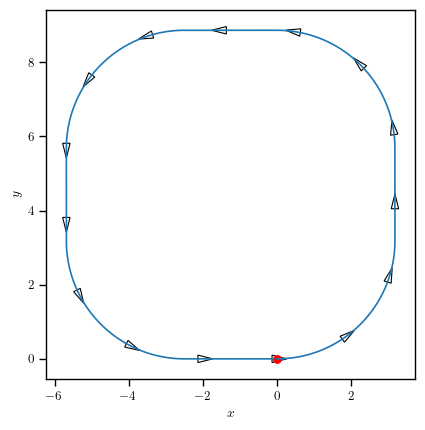

In [24]:
ax = plotter.two_d_trajectory_attitude_plot(trajectory,0.10,20,color="black")
ax.set_aspect("equal")
ax.scatter(trajectory[0,0],trajectory[0,1],s=30,color='red')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
plt.savefig('trajectory.svg')

Text(0.5, 0, '$t$')

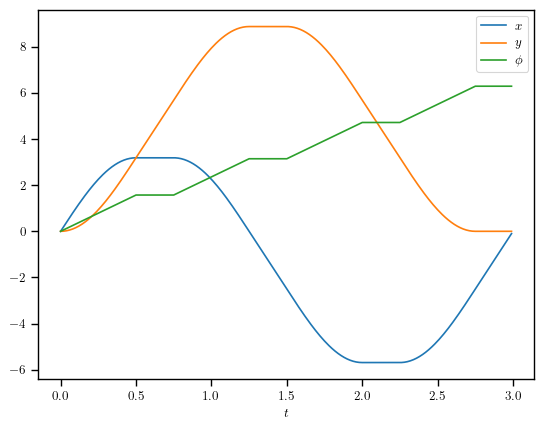

In [25]:
plt.plot(t_span,trajectory, label=[r"$x$",r"$y$",r"$\phi$"])
plt.legend()
plt.xlabel(r'$t$')

In [26]:
desired_trajectory = trajectory[:,:2]

Create a controller that would allow the vehicle follows the desired trajectory.
Using a combination of two PI controllers, responsible for maintaining the speed and the angular velocity, we can write
$e = x_d(t)-x(t)$
$v_x(t) = K_{p,v} \|e(t)\|+ \int_0^t K_{i,v} \|e(s)\| ds$
$\phi_d = \text{atan2}(ey,ex)$
$\dot{\phi} = K_{p,\phi} (\phi_d(t)-\phi(t)) + \int_0^t K_{i,\phi} (\phi_d(s)-\phi(s)) ds$

In [80]:
controlled_trajectory = np.zeros_like(trajectory)
controlled_trajectory[0] = np.array([-1.5,2,np.pi/2])

Propagate the dynamics with control

In [81]:
K_p_v = 1e1
K_i_v = 1e-1
K_p_phi = 6e1
K_i_phi = 1e-2

sum_norm_e = 0
sum_e_phi = 0
for i in range(t_span.shape[0]-1):
    e = desired_trajectory[i,:2] - controlled_trajectory[i,:2]
    norm_e = np.linalg.norm(e)
    v_x = K_p_v*norm_e + K_i_v*sum_norm_e
    sum_norm_e += norm_e
    phi_d = np.arctan2(e[1],e[0])

    #since phi_d can only be [0,2pi] this need to be handled properly
    if np.absolute(phi_d-controlled_trajectory[i,-1])>1.8*np.pi:
        phi_d=phi_d+2*np.pi#*(controlled_trajectory[i,-1]//2*np.pi)

    e_phi = (phi_d-controlled_trajectory[i,-1])
    sum_e_phi += e_phi
    phi_dot = K_p_phi*e_phi + K_i_phi*sum_e_phi
    nu = np.array([v_x,0.,phi_dot])
    controlled_trajectory[i+1] = ode.rk_one_step(kinematic_dynamic,controlled_trajectory[i],dt,nu)
    # controlled_trajectory[i+1] = controlled_trajectory[i] + dt* kinematic_dynamic(controlled_trajectory[i],nu)

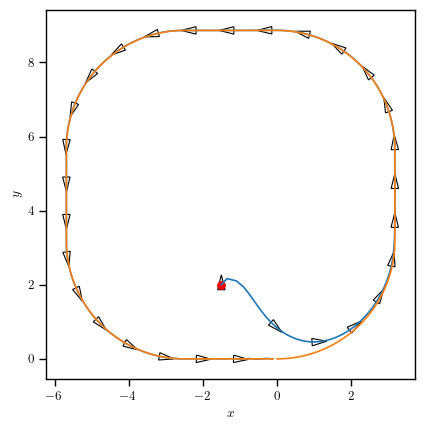

In [82]:
ax = plotter.two_d_trajectory_attitude_plot(controlled_trajectory,0.10,10,color="black")
ax.plot(desired_trajectory[:,0],desired_trajectory[:,1])
ax.set_aspect("equal")
ax.scatter(controlled_trajectory[0,0],controlled_trajectory[0,1],s=30,color='red')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
plt.savefig('controlled_trajectory.svg')

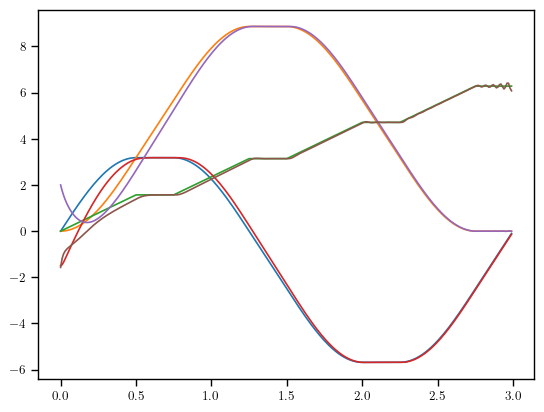

In [79]:
plt.plot(t_span,trajectory)
plt.plot(t_span,controlled_trajectory)